In [1]:
from yolo import *
from annotation_helper import *

The basic idea is that it is very tedious and unscalable to label the images by hand, so we will use an open source tool to transform masks to annotations, to do that we need to generate masks for all the images in our dataset


so the plan so far is :

1- apply thresholding to image

2- from threshold create binary masks 

3- from the binary masks create annotations for the class "weld" or "seam"

4- repeat step (2-3-4) to all images which will result in a folder named "masks" from step 2 and a folder named "labels\annotations" from step 3

5- start training yolo on the masks and labels data, this should be fairly easy given the code in "welding.main/yolo8.ipynb"

6- test the model on the real and generated images.

##### apparently we have a tool to transform the annotation to a binary mask, but we don't have an annotation. This can be done manually using free tools like cvat and so on, but we want to do it automatically using filters and edge detection 

## using thresholding to create a binary mask

In [2]:
## adaptive thresholding ??!


In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import json
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa

In [4]:
# YOLO
yolo_output_dir = "./Annotations"
yolo_color = (0, 255, 0)

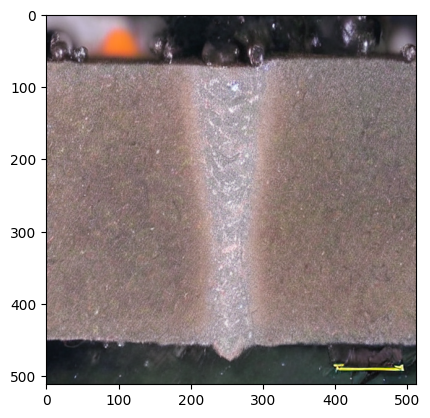

In [5]:
## reading the image file 
image= cv2.imread('AI_GENERATED_DATA/AIGD1/00009-3064401332.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)


In [6]:
image.shape

(512, 512, 3)

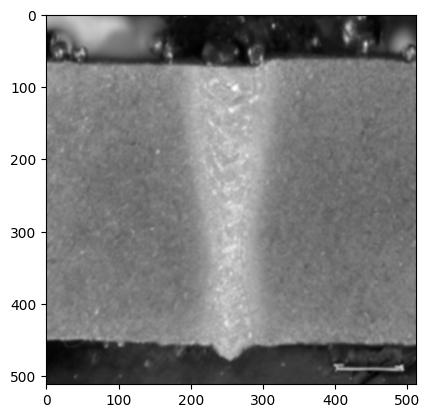

In [7]:
# now we are just going to transofrom it to gray in order to apply thresholding
blurred_img = cv2.GaussianBlur(image, (7, 7), 0)

blurredGray = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)


plt.imshow(blurredGray, cmap='gray')

In [8]:
## we create the binary image by thresholding 
ret, image_binary=cv2.threshold(blurredGray, 155, 250, cv2.THRESH_BINARY)
ret, image_binary_inv=cv2.threshold(blurredGray, 155, 250, cv2.THRESH_BINARY_INV)
ret, image_binary_trunc=cv2.threshold(blurredGray, 155, 250, cv2.THRESH_TRUNC)
ret, image_binary_tozero=cv2.threshold(blurredGray, 155, 250, cv2.THRESH_TOZERO)


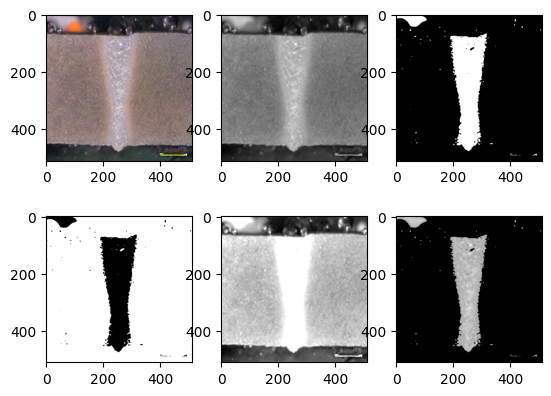

In [9]:
plt.subplot(2,3,1)
plt.imshow(image)
plt.subplot(2,3,2)
plt.imshow(blurredGray, 'gray')
plt.subplot(2,3,3)
plt.imshow(image_binary, 'gray')
plt.subplot(2,3,4)
plt.imshow(image_binary_inv, 'gray')
plt.subplot(2,3,5)
plt.imshow(image_binary_trunc, 'gray')
plt.subplot(2,3,6)
plt.imshow(image_binary_tozero, 'gray')

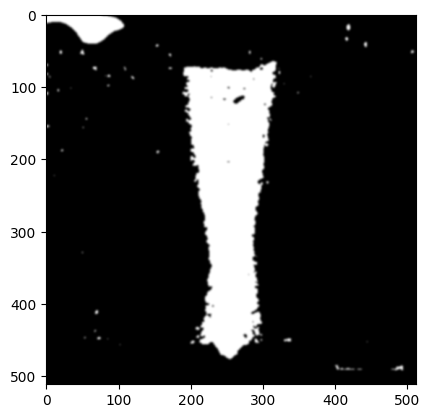

In [10]:
blurred_mask=blur = cv2.GaussianBlur(image_binary, (7, 7), 0)
plt.imshow(blurred_mask,cmap='gray')

## now we create the masks

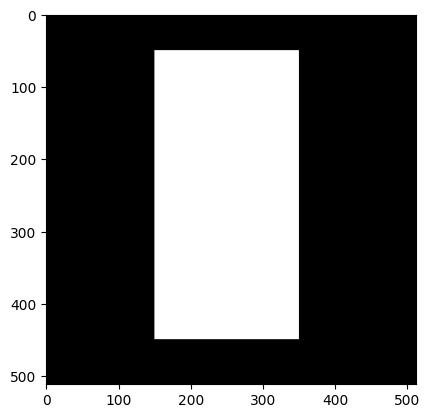

In [11]:
mask=np.zeros(blurredGray.shape, np.uint8)
mask[ 50:450,150:350]=255
plt.imshow(mask, cmap='gray')

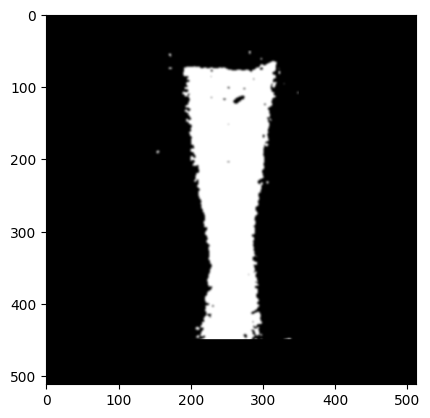

In [12]:
final_mask=cv2.bitwise_and(blurred_mask,blurred_mask,mask=mask)
plt.imshow(final_mask, cmap='gray')

In [13]:
mask.shape

(512, 512)

In [14]:
final_mask = cv2.merge([final_mask, final_mask, final_mask])

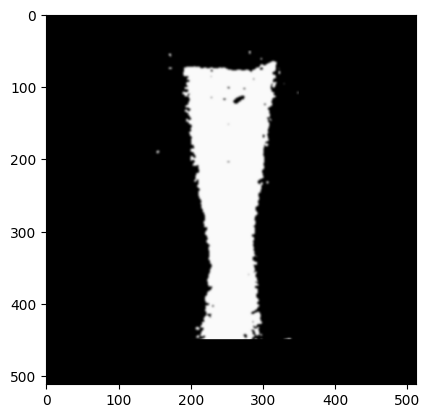

In [15]:
plt.imshow(final_mask,cmap='gray')

In [16]:
## saving the masks
dir=yolo_output_dir+'/masks'
if not os.path.exists(dir):
        os.makedirs(dir)
image_path= dir+'/image1.png'

print(image_path)
cv2.imwrite(image_path, final_mask)


./Annotations/masks/image1.png


True

### Now to generalize this solution so that we can create masks for all of our data by defining a single function

In [17]:
def image_to_mask(image_path):
    ## reading the image file 
    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # now we are just going to transofrom it to gray in order to apply thresholding
    blurred_img = cv2.GaussianBlur(image, (7, 7), 0)
    
    blurredGray = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)
    
    
    ret, image_binary=cv2.threshold(blurredGray, 155, 250, cv2.THRESH_BINARY)
    blurred_mask=blur = cv2.GaussianBlur(image_binary, (7, 7), 0)
    mask=np.zeros(blurredGray.shape, np.uint8)
    mask[ 50:450,150:350]=255
    final_mask=cv2.bitwise_and(blurred_mask,blurred_mask,mask=mask)
    final_mask = cv2.merge([final_mask, final_mask, final_mask])
    return final_mask



In [19]:
def mask_all(dir_images, dir_masks):

    for image_paths in os.listdir(dir_images):
        image_path=  os.path.join(dir_images, image_paths)
        mask_to_save=image_to_mask(image_path)
        if not os.path.exists(dir_masks):
                os.makedirs(dir_masks)
        mask_path= dir_masks+"/"+ image_paths   
        cv2.imwrite(mask_path, mask_to_save)
generated_images_paths='./AI_GENERATED_DATA/AIGD1'
dir=yolo_output_dir+'/masks'
mask_all(generated_images_paths, dir)



So now we hopefully created a reasonable mask for all our images, we are going to try to annotate it 


## now to annotating for Yolo based on the masks that we aquired

yolo.annotate(**params)
image : The input mask image to be annotated.
do_display : A boolean value indicating whether or not to display the annotated image.
do_save : A boolean value indicating whether or not to save the annotated image.
annotation_color : The color of the annotation.
object_configuration : The object configuration of the annotation:
yolo.SINGLE_OBJ : Single object.
yolo.MULTIPLE_OBJ : Multiple objects.
do_cvt : A boolean value indicating whether or not to convert the image to RGB.


 Annotating image:  test


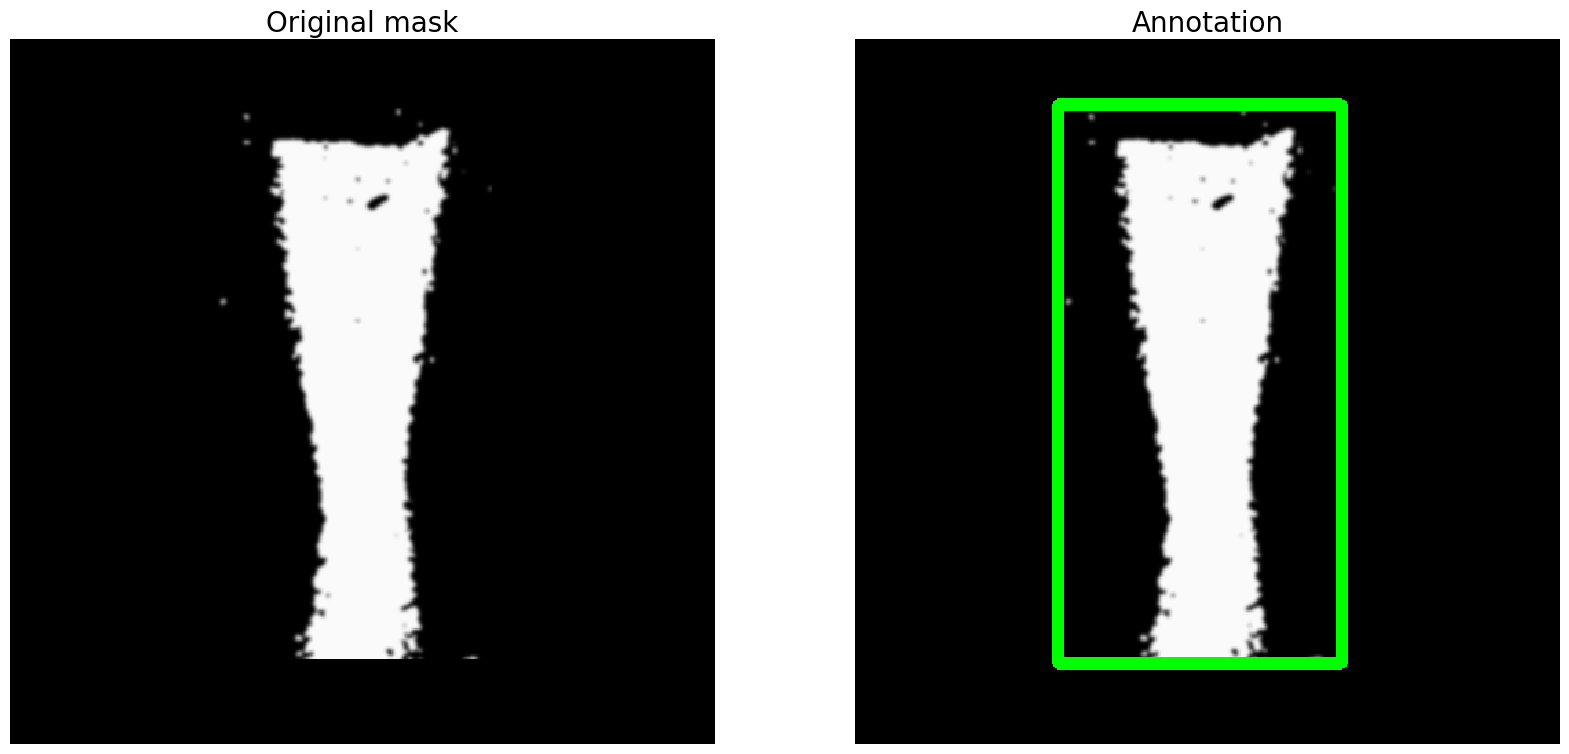

 Succesfully saved image:  test 


------------------------------------------------------------------------------------------------------------------------


In [18]:
# id_, name, image, project_name, category, directory = im
bbox_im = (0, 'test', final_mask, 'Weld', 'Weld', yolo_output_dir)
bbox_coord=annotate(bbox_im,True, True , yolo_color,object_configuration=SINGLE_OBJ, do_cvt=True )

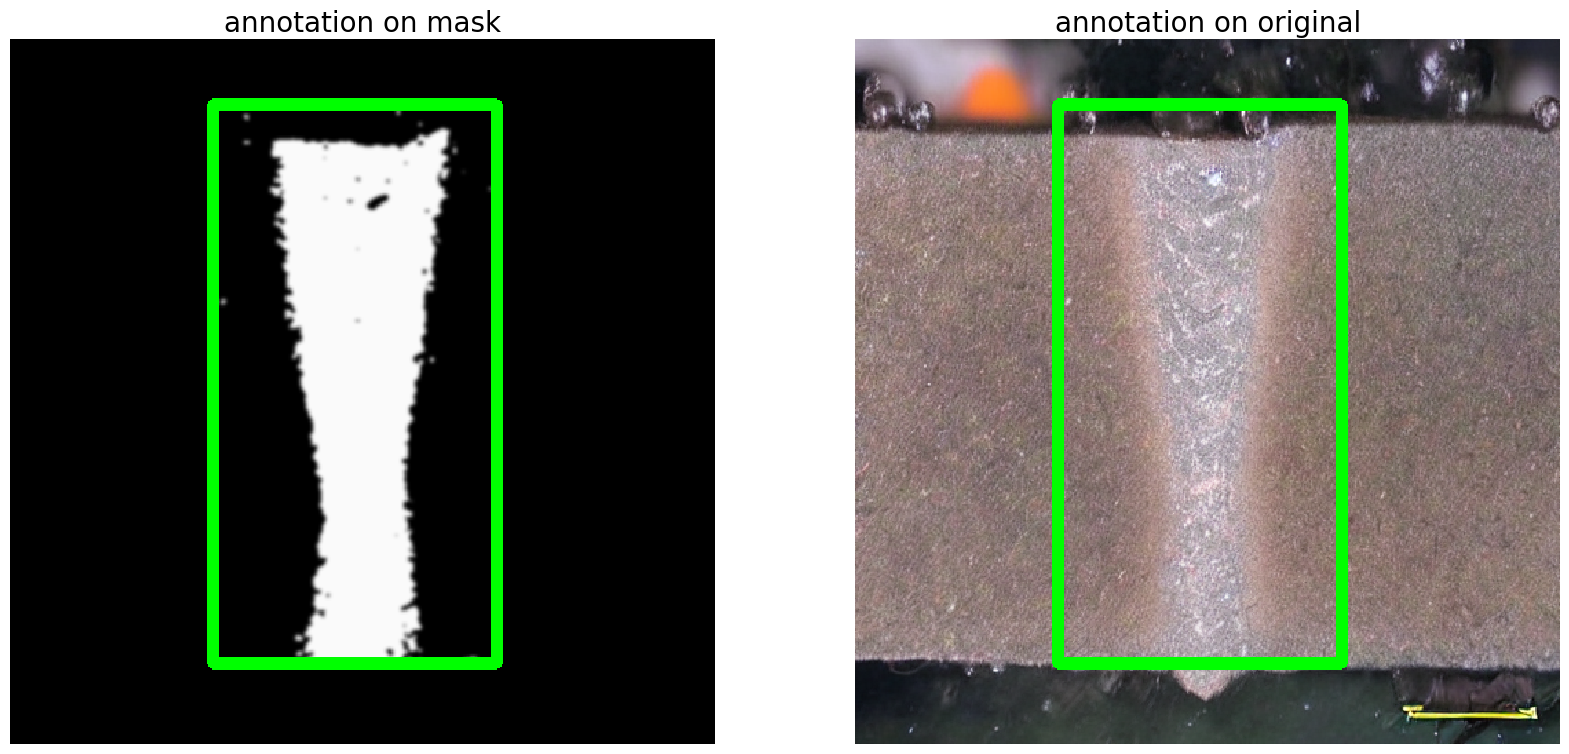

In [149]:
for contour in bbox_coord['contours']:
            x, y, w, h = contour
            cv2.rectangle(final_mask, (x, y),
                          (x+w, y+h), yolo_color, 7)
            cv2.rectangle(image, (x, y),
                          (x+w, y+h), yolo_color, 7)
plt.subplot(121)
plt.rcParams['axes.titlesize'] = 20
plt.title('annotation on mask')
plt.imshow(final_mask, interpolation='nearest')
plt.axis('off')

plt.subplot(122)
plt.rcParams['axes.titlesize'] = 20
plt.title('annotation on original')
plt.imshow(image, interpolation='nearest')
plt.axis('off')
plt.show()

#### Here we can see that we successfully annotated a weld on a single image, and that is left is to annotate the rest of the images in order to train YOLO

In [20]:
image_id = 0


for mask_name in os.listdir(dir):
    mask_path=os.path.join(dir, mask_name)
    # print(mask_path)
    image = cv2.imread(os.path.join(dir, mask_name))
    # plt.imshow(image, cmap='gray')
    annotate((image_id, mask_name, image, 'weld', 'weld', yolo_output_dir),
                  False, True, annotation_color=yolo_color,object_configuration=SINGLE_OBJ, do_cvt=True)
    image_id += 1



 Annotating image:  00009-3064401332.png
 Succesfully saved image:  00009-3064401332.png 


------------------------------------------------------------------------------------------------------------------------

 Annotating image:  00017-2645120218.png
 Succesfully saved image:  00017-2645120218.png 


------------------------------------------------------------------------------------------------------------------------

 Annotating image:  00018-2858108939.png
 Succesfully saved image:  00018-2858108939.png 


------------------------------------------------------------------------------------------------------------------------

 Annotating image:  00022-2858108943.png
 Succesfully saved image:  00022-2858108943.png 


------------------------------------------------------------------------------------------------------------------------

 Annotating image:  00024-2858108945.png
 Succesfully saved image:  00024-2858108945.png 


---------------------------------------------------

### By this we have annotated all of our images and we need to start training YOLO on this dataset

## Finally we can start training yolo on the annotated data